## Poets, meet Natural Language Processing

### Extract the data

In [1]:
# Dependencies to read the SQLite database
import pandas as pd
import sqlite3
from pprint import pprint
import numpy as np
import math
import re
from time import time
from IPython.core.display import clear_output

In [2]:
def create_dataframe(poet):
    """ Load the data from database into a dataframe """
    df = pd.read_sql_query(f"SELECT * FROM {poet};", conn)
    return df

In [3]:
# Connect to the poetry database
conn = sqlite3.connect("db/Poetry.db")

In [4]:
# Create a list of unique poets
poet_list = ["Frost", "Yeats", "Kipling"]

# Iterate through the list to create a list of dataframes
poems_df = [create_dataframe(poet) for poet in poet_list]

In [5]:
# Disconnect from the poetry database
conn.close()

In [6]:
# Just in case there are nulls in the dataframe, convert these to NaN
for x in range(len(poems_df)):
    poems_df[x].replace("None", np.nan, inplace = True)

### Feature extraction

#### Year of publication

In [7]:
# Get information about publication year (various sources)
pubyear_Frost = [1913, 1916, 1928, 1914, 1916, 1916, 1923, 1923, 1928, 1923,
           1923, 1923, 1920, 1914, 1923, 1913, 1914, 1913, 1917, 1923,
           1916, 1913, 1923, 1923, 1923, 1914, 1942, 1923, 1916, 1914,
           1916, 1918, 1916, 1923, 1913, 1914, 1920]

pubyear_Yeats = [1938, 1914, 1933, 1916, 1921, 1919, 1904, 1913, 1919, 1933,
                 1932, 1889, 1916, 1898, 1927, 1938, 1904, 1916, 1921, 1915,
                 1938, 1909, 1928, 1916, 1916, 1899, 1939, 1916, 1899, 1916,
                 1899, 1917, 1892, 1914, 1917, 1889, 1921, 1889, 1899, 1892,
                 1928, 1917, 1914, 1889, 1892, 1892, 1892, 1933, 1914, 1933,
                 1917, 1914, 1933, 1912, 1919, 1935, 1917, 1914, 1934, 1934,
                 1934, 1916, 1916, 1935, 1916, 1919, 1912, 1919, 1914, 1916,
                 1916, 1912, 1919, 1916, 1916, 1914, 1912, 1934, 1914, 1912,
                 1914, 1916]

pubyear_Kipling = [1922] * 416 + [1919, 1922, 1920, 1902, 1904, 1895, 1904, 1917, 1895, 1916, 
                                  1920, 1919, 1922, 1921, 1922, 1919, 1902, 1922, 1904, 1895,
                                  1917, 1920, 1895, 1922, 1896, 1895, 1922, 1895, 1917, 1917,
                                  1920, 1915, 1922, 1922]

pubyears_list = [pubyear_Frost, pubyear_Yeats, pubyear_Kipling] 

In [8]:
for x in range(len(poems_df)):
    poems_df[x]["pub_year"] = pubyears_list[x]

In [9]:
# Preview the dataframes
poems_df[2].head()

,index,title,link,lines,poet,pub_year
0,0,Prelude,https://www.bartleby.com/364/1.html,(To Departmental Ditties)I HAVE eaten your bre...,Rudyard Kipling,1922
1,1,A General Summary,https://www.bartleby.com/364/2.html,WE are very slightly changed\nFrom the semi-ap...,Rudyard Kipling,1922
2,2,Army Headquarters,https://www.bartleby.com/364/3.html,Old is the song that I sing\nOld as my unpaid ...,Rudyard Kipling,1922
3,3,"Study of an Elevation, in Indian Ink",https://www.bartleby.com/364/4.html,This ditty is a string of lies.\nButhow the de...,Rudyard Kipling,1922
4,4,Delilah,https://www.bartleby.com/364/5.html,"We have another Viceroy now, those days are de...",Rudyard Kipling,1922


In [10]:
# Define a function that selects the relevant columns
def BuildDataframe(df):
    """ Create a new dataframe containing metadata """
    
    df1 = df[["title", "poet", "pub_year"]] # Select the relevant columns from the dataframe
    
    lines = df["lines"].values.tolist() # Convert the lines column into a list of strings
    
    processed = []
    
    for line in lines:
        if pd.isnull(line):
            processed.append(line) # Keep the "nan" value
        else:
            x = line.replace("\n", " ") # Replace special characters with spaces
            x = x.lower() # Convert the string to lower case
            processed.append(x) # Add to empty list
    
    df1["lines"] = processed
    
    return df1

In [11]:
# For each dataframe, choose the relevant columns
poems_df1 = [BuildDataframe(df) for df in poems_df] 

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# Preview each dataframe
# [0] = Frost, [1] = Yeats, [2] = Kipling
poems_df1[0].head()

,title,poet,pub_year,lines
0,October,Robert Frost,1913,"o hushed october morning mild, thy leaves have..."
1,"‘Out, Out—’",Robert Frost,1916,the buzz saw snarled and rattled in the yard a...
2,Acquainted with the Night,Robert Frost,1928,i have been one acquainted with the night. i h...
3,After Apple-Picking,Robert Frost,1914,my long two-pointed ladder's sticking through ...
4,Birches,Robert Frost,1916,when i see birches bend to left and right acro...


In [13]:
# Concatenate the dataframes
poems_df2 = pd.concat(poems_df1)
poems_df2.shape

(569, 4)

In [14]:
# Drop rows with null values
poems_df3 = poems_df2.dropna()

# Drop rows with duplicate titles
poems_df3 = poems_df3.drop_duplicates(subset = "title", keep = "first")

# Reset dataframe index
poems_df3 = poems_df3.reset_index(drop = True)

# Inspect shape of the resulting dataframe
poems_df3.shape

(544, 4)

#### Poem length and lexical diversity

In [15]:
# Create lists of titles, lines, and poets 
titles_list = poems_df3["title"].values.tolist()
lines_list = poems_df3["lines"].values.tolist()
poets_list = poems_df3["poet"].values.tolist()
years_list = poems_df3["pub_year"].values.tolist()

In [16]:
# Get length of the entire poem for each poem in each dataframe
lengths_list = [len(lines.split()) for lines in lines_list]
len(lengths_list)

544

#### Transform the data

In [17]:
# Dependencies
import re, string

import nltk
# nltk.download("punkt")
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#### Tokenise, Remove Stop Words, Lemmatise
Reference for lemmatisation: https://marcobonzanini.com/2015/01/26/stemming-lemmatisation-and-pos-tagging-with-python-and-nltk/

In [18]:
# Remove stop words from the list
stops = stopwords.words("english")
exclude = list(set(string.punctuation)) + ['’']

# Lemmatise the words in each list to retain their roots
lemmatiser = WordNetLemmatizer()

In [19]:
def tokeniser(poem):
    """ Processes the poem into tokens and removes stop words, numbers, and punctuations """
    
    translator = re.compile("[%s]" % re.escape(string.punctuation))
    
    words = poem[0: poem.find("note .")] # remove all substrings that start with "note ."
    words = words.replace("[back]", "") # remove all "[back]" substrings
    words1 = translator.sub(" ", words) # Replace punctuations with white space
    words2 = re.sub(" +", " ", words1).strip() # Remove extra white spaces
    
    words3 = word_tokenize(words2) # Create a list of words
    words4 = [word for word in words3 if word not in stops] # Filter the keywords
    words5 = [word for word in words4 if word not in exclude] # Filter the keywords
    words6 = [lemmatiser.lemmatize(word, pos = "v") for word in words5] # Lemmatise each word
    words_list = [lemmatiser.lemmatize(word, pos = "n") for word in words6] # Lemmatise each word
    
    preprocessed_text = " ".join(words_list) # Convert the list of strings back to one string

    
    return words_list, preprocessed_text # Returns a tuple

In [20]:
# Tokenise each poem in each dataframe and create a processed text
start_time = ()
tokenised_poems = []   
for x in range(len(lines_list)):
    print(f"Now calculating for {x}th poem.")
    %time y = tokeniser(lines_list[x]) 
    tokenised_poems.append(y)
    clear_output(wait = True)
print(f"End of {len(lines_list)} calculations.")    

# Unpack the tuples into lists of tokens and of filtered poems
df_tokens, df_filtered = map(list, zip(*tokenised_poems))

# Determine the length of each filtered poem
df_filtered_length = [len(df) for df in df_tokens]

End of 544 calculations.


In [21]:
# Add three new columns to each dataframe for tokens and filtered text
poems_df3["tokens"] = df_tokens
poems_df3["filteredPoem"] = df_filtered
poems_df3["filteredLength"] = df_filtered_length

In [22]:
# Preview the dataframe
poems_df3 = poems_df3.reset_index(drop = True)
poems_df3.head()

,title,poet,pub_year,lines,tokens,filteredPoem,filteredLength
0,October,Robert Frost,1913,"o hushed october morning mild, thy leaves have...","[hush, october, morning, mild, thy, leave, rip...",hush october morning mild thy leave ripen fall...,80
1,"‘Out, Out—’",Robert Frost,1916,the buzz saw snarled and rattled in the yard a...,"[buzz, saw, snarl, rattle, yard, make, dust, d...",buzz saw snarl rattle yard make dust drop stav...,154
2,Acquainted with the Night,Robert Frost,1928,i have been one acquainted with the night. i h...,"[one, acquaint, night, walk, rain—and, back, r...",one acquaint night walk rain—and back rain out...,55
3,After Apple-Picking,Robert Frost,1914,my long two-pointed ladder's sticking through ...,"[long, two, point, ladder, stick, tree, toward...",long two point ladder stick tree toward heaven...,142
4,Birches,Robert Frost,1916,when i see birches bend to left and right acro...,"[see, birch, bend, leave, right, across, line,...",see birch bend leave right across line straigh...,245


In [23]:
# Number of poems
poets = list(set(poets_list))

for x in range(len(poets)):
    print (f"There are {poems_df3.loc[poems_df3['poet'] == poets[x]].shape[0]} poems written by {poets[x]}.")

There are 82 poems written by William Butler Yeats.
There are 425 poems written by Rudyard Kipling.
There are 37 poems written by Robert Frost.


In [24]:
# Longest and shorted poems and their lengths
for x in range(len(poets)):

    df = poems_df3.loc[poems_df3["poet"] == poets[x]]
    longest_length = df["filteredLength"].max()
    shortest_length = df["filteredLength"].min()
    mean_length = round(df["filteredLength"].mean(),0)
    
    longest_title = df[df["filteredLength"] == longest_length]["title"].item().encode("ascii", "ignore")\
    .decode("utf-8")
    shortest_title = df[df["filteredLength"] == shortest_length]["title"].item().encode("ascii", "ignore")\
    .decode("utf-8")
        # .encode("ascii", "ignore").decode("utf-8") removes the ascii and the unicode characters
        # .item() extracts the value of each element in a pandas series
    
    print(f"Author: {poets[x]}\n")
    print(f"Longest Poem: Title = {longest_title}, Length = {longest_length}")
    print(f"Shortest Poem: Title = {shortest_title}, Length = {shortest_length}")
    print(f"Average Poem Length = {mean_length}")
    print("=====\n")

Author: William Butler Yeats

Longest Poem: Title = The Two Kings, Length = 1018
Shortest Poem: Title = A Needle's Eye, Length = 13
Average Poem Length = 111.0
=====

Author: Rudyard Kipling

Longest Poem: Title = MAndrews Hymn, Length = 1287
Shortest Poem: Title = An Astrologers Song, Length = 2
Average Poem Length = 195.0
=====

Author: Robert Frost

Longest Poem: Title = The Death of the Hired Man, Length = 688
Shortest Poem: Title = Dust of Snow, Length = 15
Average Poem Length = 125.0
=====



In [25]:
# List of unique words; how many unique words per poem?
unique_words = [list(set(x)) for x in df_tokens]
length_unique_words = [len(x) for x in unique_words]

In [26]:
# Lexical diversity: proportion of unique words among all the words in the poem
# I used the filtered words
lex_div = [round(length_unique_words[i] / df_filtered_length[i],3) for i in range(len(length_unique_words))]
lex_div[500]

0.833

### Word importance
Source: https://stevenloria.com/tf-idf/

In [27]:
# Dependencies
import math
from textblob import TextBlob as tb

In [28]:
# Create a function that calculates term frequency
def tf(word, poem):
    return poem.words.count(word) / len(poem.words)

# Create a function that determines the number of documents that contain a certain word
def n_docs(word, poemlist):
    return sum(1 for poem in poemlist if word in poem.words)

# Create a function that determines the inverse document frequency (IDF)
# IDF = how common a word is among all the documents in poemlist
def idf(word, poemlist):
    return math.log(len(poemlist) / (1 + n_docs(word, poemlist)))

def tdidf(word, poem, poemlist):
    return tf(word, poem) * idf(word, poemlist)

In [29]:
# Create the poemlist from df["lines"]
%time poemlist = [tb(poem) for poem in poems_df3["filteredPoem"]]
poemlist

CPU times: user 13.4 ms, sys: 730 µs, total: 14.1 ms
Wall time: 14.5 ms


[TextBlob("hush october morning mild thy leave ripen fall tomorrow wind wild waste crow forest call tomorrow may form go hush october morning mild begin hour day slow make day seem u le brief heart averse beguile beguile u way know release one leaf break day noon release another leaf one tree one far away retard sun gentle mist enchant land amethyst slow slow grape sake whose leave already burn frost whose cluster fruit must else lost— grape sake along wall"),
 TextBlob("buzz saw snarl rattle yard make dust drop stave length stick wood sweet scent stuff breeze draw across lift eye could count five mountain range one behind sunset far vermont saw snarl rattle snarl rattle run light bear load nothing happen day do call day wish might say please boy give half hour boy count much save work sister stand beside apron tell ‘ supper word saw prove saw know supper mean leap boy hand seem leap— must give hand however neither refuse meet hand boy first outcry rueful laugh swing toward hold hand h

In [30]:
# Create an empty list to be filled with text blobs from cleaning poemlist
poemlist2 = []

# Loop through the poemlist
for i in range(0, len(poemlist)):
    
    # Remove words that are shorter than 3 characters
    new_string = ' '.join([w for w in str(poemlist[i]).split() if len(w) > 3])
    
    # Replace emm dash with space
    new_string2 = new_string.replace("—", " ")
    
    # Convert string to text blob
    new_string2 = tb(new_string2)
    
    # Append the text blob to the list of text blobs
    poemlist2.append(new_string2)
    
poemlist2

[TextBlob("hush october morning mild leave ripen fall tomorrow wind wild waste crow forest call tomorrow form hush october morning mild begin hour slow make seem brief heart averse beguile beguile know release leaf break noon release another leaf tree away retard gentle mist enchant land amethyst slow slow grape sake whose leave already burn frost whose cluster fruit must else lost  grape sake along wall"),
 TextBlob("buzz snarl rattle yard make dust drop stave length stick wood sweet scent stuff breeze draw across lift could count five mountain range behind sunset vermont snarl rattle snarl rattle light bear load nothing happen call wish might please give half hour count much save work sister stand beside apron tell supper word prove know supper mean leap hand seem leap  must give hand however neither refuse meet hand first outcry rueful laugh swing toward hold hand half appeal half keep life spill all  since enough know work though child heart  spoil hand off  doctor come sister hand

In [32]:
# Calculate the most important words
start_time = time()
impt_words = []
for i, poem in enumerate(poemlist2):
    print(f"Now processing {i}th poem.")
    scores = {word: tdidf(word, poem, poemlist2) for word in poem.words}
    sorted_words = sorted(scores.items(), key = lambda x: x[1], reverse = True)
    clear_output(wait = True)
    
    for word, score in sorted_words[:5]:
        impt_words.append((i, word, round(score, 5)))
        
elapsed_time = time() - start_time
print(f"End of {len(poemlist2)} calculations. Elapsed time: {round(elapsed_time/60, 3)} min.")        

End of 544 calculations. Elapsed time: 2.674 min.


In [33]:
impt_words

[(0, 'mild', 0.15116),
 (0, 'tomorrow', 0.15116),
 (0, 'beguile', 0.15116),
 (0, 'grape', 0.13868),
 (0, 'october', 0.13394),
 (1, 'snarl', 0.1208),
 (1, 'rattle', 0.09593),
 (1, 'supper', 0.08054),
 (1, 'doctor', 0.07688),
 (1, 'hand', 0.06112),
 (2, 'acquaint', 0.2261),
 (2, 'outwalked', 0.12187),
 (2, 'saddest', 0.12187),
 (2, 'unearthly', 0.12187),
 (2, 'luminary', 0.12187),
 (3, 'apple', 0.23155),
 (3, 'ladder', 0.10904),
 (3, 'sleep', 0.09991),
 (3, 'pick', 0.07761),
 (3, 'bough', 0.06292),
 (4, 'birch', 0.08838),
 (4, 'swinger', 0.05496),
 (4, 'tree', 0.04991),
 (4, 'climb', 0.04718),
 (4, 'bend', 0.04416),
 (5, 'christmas', 0.09607),
 (5, 'tree', 0.07832),
 (5, 'dollar', 0.06501),
 (5, 'cent', 0.06086),
 (5, 'pasture', 0.05627),
 (6, 'hemlock', 0.43336),
 (6, 'crow', 0.32509),
 (6, 'mood', 0.31117),
 (6, 'part', 0.2534),
 (6, 'shake', 0.23354),
 (7, 'favor', 0.31143),
 (7, 'destruction', 0.2504),
 (7, 'suffice', 0.24184),
 (7, 'taste', 0.22787),
 (7, 'perish', 0.21189),
 (8, 's

In [34]:
# Create a dictionary of indices (article numbers) and poets
poet_dict = dict(zip(poems_df3.index, poems_df3.poet.tolist()))
title_dict = dict(zip(poems_df3.index, poems_df3.title.tolist()))

In [35]:
# Create a dataframe of important words per poem
poems_df4 = pd.DataFrame(impt_words, columns = ["PoemNo", "Word", "TF-IDF"])

# Map the poets and the titles to the important words based on the dictionary
poems_df4["Poet"] = poems_df4["PoemNo"].map(poet_dict)
poems_df4["Title"] = poems_df4["PoemNo"].map(title_dict)
poems_df4.head()

,PoemNo,Word,TF-IDF,Poet,Title
0,0,mild,0.15116,Robert Frost,October
1,0,tomorrow,0.15116,Robert Frost,October
2,0,beguile,0.15116,Robert Frost,October
3,0,grape,0.13868,Robert Frost,October
4,0,october,0.13394,Robert Frost,October


In [36]:
# Save df2 as a sqlite database table (for Javascript use later)
conn = sqlite3.connect("db/Poetry.db")

# Create a database table from the dataframe
poems_df4.to_sql("tfidf", conn, if_exists = "replace", index = False)

# Preview the database table
pd.read_sql_query("select * from tfidf;", conn).head()

,PoemNo,Word,TF-IDF,Poet,Title
0,0,mild,0.15116,Robert Frost,October
1,0,tomorrow,0.15116,Robert Frost,October
2,0,beguile,0.15116,Robert Frost,October
3,0,grape,0.13868,Robert Frost,October
4,0,october,0.13394,Robert Frost,October


In [37]:
conn.close()

In [38]:
# Group the important words by poem title
poems_df5 = pd.DataFrame(poems_df4.groupby(["Title", "Word"])["TF-IDF"].mean())
poems_df5

TF-IDF
Title                     Word                 
A Ballad of Burial        praxeds       0.04247
                          sake          0.26916
                          solemnly      0.04247
                          tonga         0.07443
                          umballagoods  0.04247
A Ballade of Jakko Hill   fate          0.05693
                          hill          0.08761
                          jakko         0.20195
                          mist          0.09770
                          wait          0.06860
A Boy Scouts Patrol Song chorus        0.16120
                          look          0.22598
                          patrol        0.19378
                          scout         0.07195
                          tight         0.06606
A BritishRoman Song      arduous       0.09343
                          hardihood     0.09343
                          rome          0.11362
                          theethee      0.09343
                          unshakeable   0.09343
A Carol                   judge         0.13478
                          lord          0.10269
                          ripen         0.10123
                          shall         0.06866
                          spring        0.12025
A Charm                   clutch        0.05143
                          fester        0.05143
                          flower        0.05510
                          restore       0.07333
                          shall         0.07584
...                                         ...
White Horses              herd          0.05709
                          horse         0.06357
                          rider         0.05582
                          trust         0.05654
                          white         0.05818
Wilful-Missing            cant          0.06002
                          miss          0.06555
                          share         0.06259
                          testify       0.16171
                          wilful        0.10780
With Drake in the Tropics admiral       0.13646
                          bell          0.05704
                          shine         0.06027
                          south         0.09231
                          unsheltered   0.05191
With Scindia to Delhi     delhi         0.05605
                          league        0.04088
                          mare          0.04489
                          populzai      0.04467
                          scindia       0.07817
Zion                      baal          0.46056
                          doorkeeper    0.08759
                          halberd       0.08759
                          present       0.10830
                          zion          0.89381
‘Out, Out—’               doctor        0.07688
                          hand          0.06112
                          rattle        0.09593
                          snarl         0.12080
                          supper        0.08054

[2716 rows x 1 columns]

### Visualise the important words

In [39]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")
import numpy as np

from ipywidgets import widgets, interactive

In [40]:
# Create a widget containing poem titles (sorted alphabetically)
titles = titles_list
titles.sort()

poem_title = widgets.Dropdown(options = ["Choose a poem..."] + titles, value = "Choose a poem...", 
                              description = "Title:", disabled = False)

In [41]:
# Create a filter based on title
def plot_it(poem_title):
    if poem_title != "Choose a poem...":
        poems_df6 = poems_df4[poems_df4["Title"] == poem_title]
        
        plt.figure(figsize = (10, 6))
        sns.set(font_scale = 1.5)
        graph = sns.barplot(y = "Word", x = "TF-IDF", data = poems_df6, palette = "Blues_d")

In [42]:
# Plot the data by poem title
interactive(plot_it, poem_title = poem_title)

interactive(children=(Dropdown(description='Title:', options=('Choose a poem...', 'A Ballad of Burial', 'A Bal…

### Sentiment Analysis - Metadata

In [43]:
# Predict sentiments based on textblobs
sentiment_polarity = [round(poem.sentiment.polarity, 3) \
                      for poem in poemlist2]
sentiment_cat = ["positive" if sp > 0
                 else "negative" if sp < 0
                 else "neutral"
                 for sp in sentiment_polarity]

In [44]:
metadata = pd.DataFrame({"PoemNo": list(poet_dict.keys()),
                         "Poet": list(poet_dict.values()),
                         "Title": list(title_dict.values()),
                         "Content": poems_df3["lines"].tolist(),
                         "Length": df_filtered_length,
                         "Sentiment": sentiment_cat,
                         "Pubn_Year": poems_df3["pub_year"].tolist(),
                         "Lexical_Diversity": lex_div}, 
                        columns = ["PoemNo", "Poet", "Title", "Length", 
                                   "Content", "Sentiment", "Pubn_Year", "Lexical_Diversity"])
metadata.head()

,PoemNo,Poet,Title,Length,Content,Sentiment,Pubn_Year,Lexical_Diversity
0,0,Robert Frost,October,80,"o hushed october morning mild, thy leaves have...",negative,1913,0.762
1,1,Robert Frost,"‘Out, Out—’",154,the buzz saw snarled and rattled in the yard a...,negative,1916,0.779
2,2,Robert Frost,Acquainted with the Night,55,i have been one acquainted with the night. i h...,positive,1928,0.873
3,3,Robert Frost,After Apple-Picking,142,my long two-pointed ladder's sticking through ...,positive,1914,0.796
4,4,Robert Frost,Birches,245,when i see birches bend to left and right acro...,positive,1916,0.714


In [45]:
# Save df2 as a sqlite database table (for Javascript use later)
conn = sqlite3.connect("db/Poetry.db")

# Create a database table from the dataframe
metadata.to_sql("metadata", conn, if_exists = "replace", index = False)

# Preview the database table
pd.read_sql_query("select * from metadata;", conn).head()

,PoemNo,Poet,Title,Length,Content,Sentiment,Pubn_Year,Lexical_Diversity
0,0,Robert Frost,October,80,"o hushed october morning mild, thy leaves have...",negative,1913,0.762
1,1,Robert Frost,"‘Out, Out—’",154,the buzz saw snarled and rattled in the yard a...,negative,1916,0.779
2,2,Robert Frost,Acquainted with the Night,55,i have been one acquainted with the night. i h...,positive,1928,0.873
3,3,Robert Frost,After Apple-Picking,142,my long two-pointed ladder's sticking through ...,positive,1914,0.796
4,4,Robert Frost,Birches,245,when i see birches bend to left and right acro...,positive,1916,0.714


In [46]:
conn.close()

### Topic Modelling
Sources: 
1. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
2. https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [47]:
# Gensim 
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [48]:
# Build the bigram and the trigram model
tokens = df_tokens
bigram = gensim.models.Phrases(tokens, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[tokens], threshold = 100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [49]:
def process_words(texts, stop_words = stops, allowed_postags = ["NOUN", "ADJ", "ADV"]):
    """ Remove stop words, create bigrams and trigrams, lemmatise """
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]    
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    nlp = spacy.load("en", disable = ["parser", "ner"])
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
        # remove stop words (again)         
        texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] \
                     for doc in texts_out]
        
        # remove words shorter than three letters       
        texts_out = [[word for word in lst if len(word) > 2] for lst in texts_out]

    return texts_out

In [51]:
# Filter text (again!)
%time filtered_text = process_words(tokens)
filtered_text

CPU times: user 1min 54s, sys: 930 ms, total: 1min 55s
Wall time: 1min 58s


[['hush',
  'october',
  'morning',
  'mild',
  'leave',
  'ripen',
  'fall',
  'tomorrow',
  'wind',
  'wild',
  'waste',
  'crow',
  'forest',
  'call',
  'tomorrow',
  'hush',
  'october',
  'morning',
  'mild',
  'hour',
  'day',
  'slow',
  'make',
  'day',
  'brief',
  'heart',
  'averse',
  'beguile',
  'beguile',
  'way',
  'release',
  'leaf',
  'break',
  'day',
  'noon',
  'leaf',
  'tree',
  'far',
  'away',
  'retard',
  'sun',
  'gentle',
  'mist',
  'enchant',
  'land',
  'amethyst',
  'slow',
  'slow',
  'grape',
  'sake',
  'leave',
  'already',
  'frost',
  'cluster',
  'fruit',
  'else',
  'grape',
  'sake',
  'wall'],
 ['snarl',
  'rattle',
  'yard',
  'dust',
  'stave',
  'length',
  'stick',
  'wood',
  'sweet',
  'scent',
  'stuff',
  'breeze',
  'draw',
  'lift',
  'eye',
  'mountain',
  'range',
  'sunset',
  'far',
  'vermont',
  'snarl',
  'rattle',
  'snarl',
  'rattle',
  'run',
  'light',
  'bear',
  'load',
  'nothing',
  'day',
  'call',
  'day',
  'wish

In [52]:
# Create dictionary
%time id2words = corpora.Dictionary(filtered_text)

# Create corpus term frequency (convert dictionary to bag-of-words)
%time corpus = [id2words.doc2bow(text) for text in filtered_text]

CPU times: user 108 ms, sys: 4.11 ms, total: 112 ms
Wall time: 109 ms
CPU times: user 72.5 ms, sys: 1.47 ms, total: 74 ms
Wall time: 73.7 ms


#### How many topics?

In [53]:
# Create a range of number of topics
num_topics = list(range(1, 21))
num_topics

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [54]:
# Define a function that calculates the coherence score 
def coherence_score(num_topics):
    """ Create a LDA model """
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2words,
                                            num_topics = num_topics,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 600,
                                            passes = 100,
                                            alpha = "auto",
                                            per_word_topics = True)
    
    """ Calculate the coherence score """
    coherence_model_lda = CoherenceModel(model = lda_model, 
                                         texts = filtered_text, 
                                         dictionary = id2words,
                                         coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    """ Perplexity """
    perplexity = lda_model.log_perplexity(corpus)
    
    return coherence_lda, lda_model, perplexity

In [55]:
# Calculate the coherence score of each number of topics
start_time = time()

coh_score = []
total_time = []
for x in num_topics:
    print(f"Now processing {x} topic/s.")
    y = coherence_score(x)[0]
    elapsed_time = time() - start_time
    total_time.append(elapsed_time)
    print(f"Elapsed time: {round(elapsed_time/60, 3)} min.")
    
    coh_score.append(y)
    
    print(f"Calculation for {x} topic completed.")  
    clear_output(wait = True)
print(f"End of {len(num_topics)} calculations. Elapsed time: {round(sum(total_time)/60, 3)} min.")    

End of 20 calculations. Elapsed time: 444.982 min.


Text(0,0.5,'Coherence score')

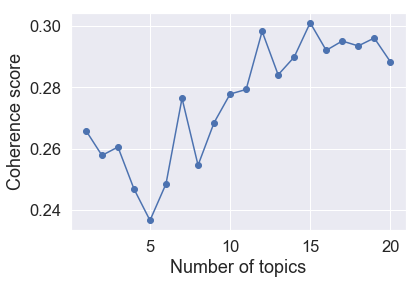

In [56]:
# Plot number of topics vs coherence score
# Find the highest coherence score before the trend flattens out
plt.plot(num_topics, coh_score, "bo-")
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")

In [ ]:
# Building the LDA model using the chosen number of topics
final_number = 6
coh_score2 = coherence_score(final_number)

# Compute Perplexity
print(f"Perplexity: {coherence_lda[2]}")
print(f"Coherence Score: {coherence_lda[0]}")

In [ ]:
# Keywords for the top 10 topics
doc_lda = lda_model[corpus]
pprint(lda_model.print_topics())

### Most important words per topic

In [ ]:
# Dependencies
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
# Create graphs of most important words per topic
# Based on the LDA model

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, corpus, id2words)
panel

In [ ]:
# Save the graph as a html page
pyLDAvis.save_html(panel, "lda.html")

### Dominant Topic in each poem

In [ ]:
def format_topics_sentences(doc_lda, ldamodel = lda_model, texts = tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(doc_lda):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), \
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(doc_lda, ldamodel = lda_model, texts = tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

### Data Visualisation

In [ ]:
# Length of text per tokenised poem
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize = (10,3), dpi = 160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(200, 1.75, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(200, 1.60, "Median : " + str(round(np.median(doc_lens))))
plt.text(200, 1.45, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(200, 1.30, "1%ile    : " + str(round(np.quantile(doc_lens, q = 0.01))))
plt.text(200, 1.15, "99%ile  : " + str(round(np.quantile(doc_lens, q = 0.99))))

plt.gca().set(xlim = (0, 300), ylabel = 'Number of Documents', xlabel = 'Document Word Count')
plt.tick_params(size = 8)
plt.xticks(np.linspace(0, 300, 9))
plt.title('Distribution of Document Word Counts', fontdict = dict(size = 10))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2, figsize = (16,14), dpi = 160, sharex = True, sharey = True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color = cols[i])
    ax.tick_params(axis = 'y', labelcolor = cols[i], color = cols[i])
    sns.kdeplot(doc_lens, color = "black", shade = False, ax = ax.twinx())
    ax.set(xlim = (0, 300), xlabel = 'Document Word Count')
    ax.set_ylabel('Number of Documents', color = cols[i])
    ax.set_title('Topic: '+str(i), fontdict = dict(size = 8, color = cols[i]))

fig.tight_layout()
fig.subplots_adjust(top = 0.90)
plt.xticks(np.linspace(0, 300, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize = 12)
plt.show()

In [ ]:
# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords = stops,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize = (10,10), sharex = True, sharey = True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size = 16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace = 0, hspace = 0)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted = False)
data_flat = [w for w_list in filtered_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize = (16,10), sharey = True, dpi = 160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x = 'word', 
           height = "word_count", 
           data = df.loc[df.topic_id == i, :], 
           color = cols[i], 
           width = 0.5, 
           alpha = 0.3, 
           label = 'Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x = 'word', 
                height = "importance", 
                data = df.loc[df.topic_id == i, :], 
                color = cols[i], width = 0.2,
                label ='Weights')
    ax.set_ylabel('Word Count', color = cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 50)
    ax.set_title('Topic: ' + str(i), color = cols[i], fontsize = 16)
    ax.tick_params(axis = 'y', left = False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], 
                       rotation = 30, 
                       horizontalalignment = 'right')
    ax.legend(loc ='upper left')
    ax_twin.legend(loc = 'upper right')

fig.tight_layout(w_pad = 2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize = 14, y = 1.05)    
plt.show()

In [ ]:
# Word colouring of N poems
from matplotlib.patches import Rectangle

def sentences_chart(lda_model = lda_model, corpus = corpus, start = 0, end = 38):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment = 'center',
                    fontsize = 16, color = 'black', transform = ax.transAxes, fontweight = 700)

            # Draw Rectangle
            topic_percs_sorted = sorted(topic_percs, key = lambda x: (x[1]), reverse = True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill = None, alpha = 1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth = 2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, 
                            color = mycolors[topics],
                            transform = ax.transAxes, 
                            fontweight = 700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment = 'left',
                    verticalalignment = 'center',
                    fontsize = 16, 
                    color = 'black',
                    transform = ax.transAxes)       

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.suptitle('Topic Coloring for Poems: ' + str(start) + ' to ' + str(end-2), \
                 fontsize = 14, y = 0.95, fontweight = 700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [ ]:
# Define a function that identifies and quantifies the dominant topics
def topics_per_document(model, corpus, start = 0, end = 1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse = True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    
    return(dominant_topics, topic_percentages)

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model = lda_model, corpus = corpus, end = -1)

In [ ]:
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns = ['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name = 'count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name = 'count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted = False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns = ['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level =0,inplace = True)

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 4), dpi = 120, sharex = True)

# Topic Distribution by Dominant Topics
ax1.bar(x = 'Dominant_Topic', 
        height = 'count', 
        data = df_dominant_topic_in_each_doc, 
        width = .5, color = 'firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + \
                               df_top3words.loc[df_top3words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size = 10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x = 'index', 
        height = 'count', 
        data = df_topic_weightage_by_doc, 
        width = .5, color = 'steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict = dict(size = 10))

plt.show()

### Create a keyword network based on term frequency and TF-IDF
(use the "to_gephi.csv" and "to_gephi2.csv" files in Gephi for visualisation)
source: https://pythondata.com/text-analytics-visualization/

In [ ]:
# Define a function that extracts the most common words per poem
def get_keywords(token_list, num):
    return Counter(token_list).most_common(num)

In [ ]:
# Convert the filtered poems into strings
poemlist3 = [str(poem) for poem in poemlist2]
token_list = [word_tokenize(poem) for poem in poemlist3]

In [ ]:
# titles = df1["title"].values.tolist()

df4 = pd.DataFrame({"title": poems, 
                    "poet": poets,
                    "filteredPoem": poemlist3})
df4.head()

In [ ]:
# Use the function to extract the top 5 words per poem
keywords = [get_keywords(tokens, 5) for tokens in token_list]

# Extract the list of keywords 
unzipped = [zip(*kw)for kw in keywords]
kw = [list(x)[0] for x in unzipped]

# Convert the list of keywords to a string
kw2 = [",".join(str(y) for y in x) for x in kw]

# Add the list of keywords to the dataframe
df4["keywords_TF"] = kw2
df4.head()

In [ ]:
# Add keywords based on TF-IDF
impt_words2 = df3.reset_index().groupby("PoemTitle")["Word"].apply(list)
df4["keywords_TF-IDF"] = [",".join(str(y) for y in x) for x in impt_words2]
df4.head()

In [ ]:
# Dataframe of keywords according to term frequency
keywordsTF = []
for i, r in df4.iterrows():
    keywords = r["keywords_TF"].split(",")
    for kw in keywords:
        keywordsTF.append((kw.strip(""), r["keywords_TF"]))
kwTF_df = pd.DataFrame(keywordsTF).rename(columns = {0: "keyword", 1: "keywords"})
kwTF_df.head()

In [ ]:
# Dataframe of keywords according to TF-IDF
keywordsTFIDF = []
for i, r in df4.iterrows():
    keywords = r["keywords_TF-IDF"].split(",")
    for kw in keywords:
        keywordsTFIDF.append((kw.strip(""), r["keywords_TF-IDF"]))
kwTFIDF_df = pd.DataFrame(keywordsTFIDF).rename(columns = {0: "keyword", 1: "keywords"})
kwTFIDF_df.head()

#### TF

In [ ]:
# Convert rows to lists
docsTF = kwTF_df["keywords"].tolist()
namesTF = kwTF_df["keyword"].tolist()

docs_list = [i.split(",")for i in docsTF]

In [ ]:
# Create an ordered dictionary of keyword and frequency of co-occurrence
from collections import OrderedDict
occurrences = OrderedDict((name, OrderedDict((name, 0) for name in namesTF)) for name in namesTF)

for i in docs_list:
    for x in range(len(i)):
        for item in i[:x] + i[x + 1:]:
            occurrences[i[x]][item] += 1

# Create a dataframe of co-occurrences
co_occur_df = pd.DataFrame.from_dict(occurrences)         
co_occur_df.head()

In [ ]:
co_occur_df.to_csv("to_gephi.csv", sep = ",")

#### TF-IDF

In [ ]:
# Convert rows to lists
docsTFIDF = kwTFIDF_df["keywords"].tolist()
namesTFIDF = kwTFIDF_df["keyword"].tolist()

docs_list = [i.split(",")for i in docsTFIDF]

In [ ]:
# Create an ordered dictionary of keyword and frequency of co-occurrence
from collections import OrderedDict
occurrences2 = OrderedDict((name, OrderedDict((name, 0) for name in namesTFIDF)) for name in namesTFIDF)

for i in docs_list:
    for x in range(len(i)):
        for item in i[:x] + i[x + 1:]:
            occurrences2[i[x]][item] += 1

# Create a dataframe of co-occurrences
co_occur_df2 = pd.DataFrame.from_dict(occurrences2)         
co_occur_df2.head()

In [ ]:
co_occur_df2.to_csv("to_gephi2.csv", sep = ",")